# 1. 1D Sequential Data and DNNs

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (06/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v1.23.5)
- Torch (tested on v1.12.1)

### Imports and CUDA

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### A Custom Time Series Dataset

...

In [75]:
# Generate time series
np.random.seed(27)
datapoints = [round(np.sin(2*np.pi*i/50), 3) for i in range(1000)]

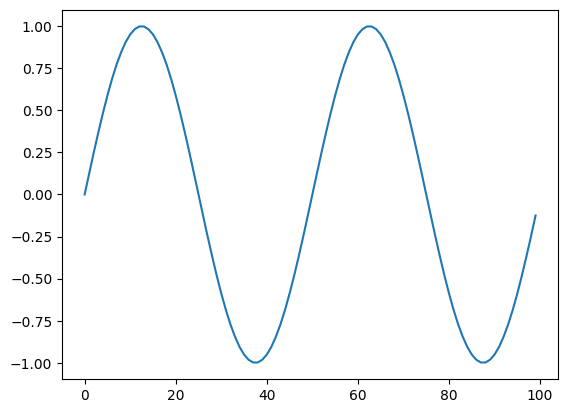

In [79]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.show()

In [77]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints):
        self.inputs_number = 1
        self.outputs_number = 1
        self.datapoints = datapoints
        self.inputs = [datapoints[i:i + self.inputs_number] for i in range(len(datapoints) - self.inputs_number)]
        self.outputs = [datapoints[i + self.outputs_number] for i in range(len(datapoints) - self.outputs_number)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs

In [78]:
# Create dataset and dataloader
dataset = CustomSeriesDataset(datapoints)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = False)

### A problem with this prediction

...

In [51]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #0: ", inputs[0])
    print("Output for sample #0: ", outputs[0])
    print("Input for sample  #25: ", inputs[25])
    print("Output for sample  #25: ", outputs[25])
    break

Input for sample #0:  tensor([0.])
Output for sample #0:  tensor([0.1250])
Input for sample  #25:  tensor([0.])
Output for sample  #25:  tensor([-0.1250])


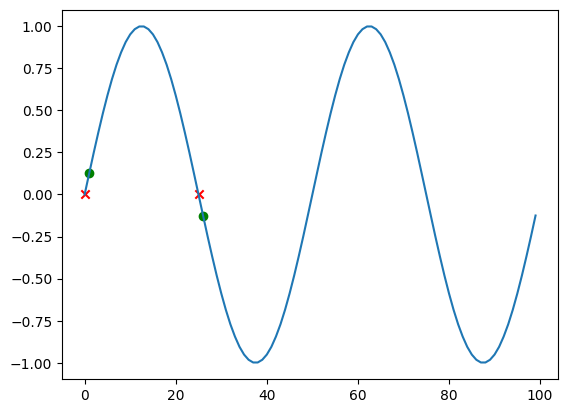

In [52]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.scatter(0, 0, c = 'r', marker = 'x')
plt.scatter(1, np.sin(2*np.pi/50), c = 'g')
plt.scatter(25, 0, c = 'r', marker = 'x')
plt.scatter(26, np.sin(2*np.pi/50*26), c = 'g')
plt.show()

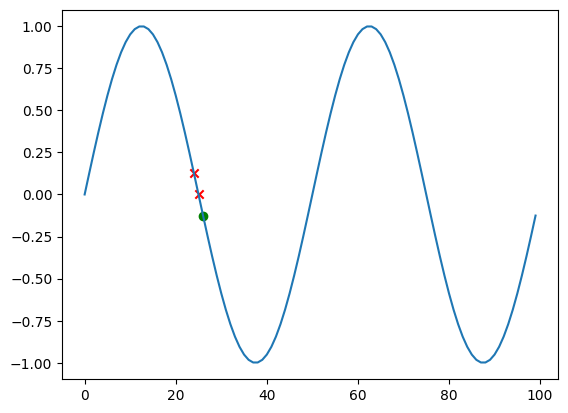

In [47]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.scatter(24, np.sin(2*np.pi/50*24), c = 'r', marker = 'x')
plt.scatter(25, 0, c = 'r', marker = 'x')
plt.scatter(26, np.sin(2*np.pi/50*26), c = 'g')
plt.show()

### Using a DNN to predict the next point of the curve

...

In [53]:
class DNN(torch.nn.Module):
    
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(1, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 1))
        
    def forward(self, inputs):
        out = self.layers(inputs)
        return out

In [54]:
model = DNN().to(device)
print(model)

DNN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


### A simple trainer function

As before, we could write a simple trainer function, like so.

In [71]:
def train(model, dataloader, num_epochs, learning_rate):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [73]:
# Train the model
model = DNN().to(device)
train(model, dataloader, num_epochs = 20, learning_rate = 0.01)

Epoch 1/20, Loss: 0.1012
Epoch 2/20, Loss: 0.0247
Epoch 3/20, Loss: 0.0097
Epoch 4/20, Loss: 0.0130
Epoch 5/20, Loss: 0.0125
Epoch 6/20, Loss: 0.0128
Epoch 7/20, Loss: 0.0129
Epoch 8/20, Loss: 0.0129
Epoch 9/20, Loss: 0.0129
Epoch 10/20, Loss: 0.0129
Epoch 11/20, Loss: 0.0128
Epoch 12/20, Loss: 0.0127
Epoch 13/20, Loss: 0.0126
Epoch 14/20, Loss: 0.0125
Epoch 15/20, Loss: 0.0126
Epoch 16/20, Loss: 0.0126
Epoch 17/20, Loss: 0.0126
Epoch 18/20, Loss: 0.0126
Epoch 19/20, Loss: 0.0126
Epoch 20/20, Loss: 0.0126


### Test model predictions

...

In [74]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #0: ", inputs[0])
    print("Output for sample #0: ", outputs[0])
    print("Model prediction for sample #0:", model(torch.tensor([[inputs[0]], ]).to(device)))
    print("Input for sample  #25: ", inputs[25])
    print("Output for sample  #25: ", outputs[25])
    print("Model prediction for sample #0:", model(torch.tensor([[inputs[25]], ]).to(device)))
    break

Input for sample #0:  tensor([0.])
Output for sample #0:  tensor([0.1250])
Model prediction for sample #0: tensor([[0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>)
Input for sample  #25:  tensor([0.])
Output for sample  #25:  tensor([-0.1250])
Model prediction for sample #0: tensor([[0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>)


### What's next?

...